# Stage II Data Modeling

In [502]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
deaths = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage I - Data and Project Understanding\Task 3 - Victor\covid_deaths_usafacts.csv")
cases = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage I - Data and Project Understanding\Task 3 - Victor\covid_confirmed_usafacts.csv")
population = pd.read_csv("covid_county_population_usafacts.csv")

### Functions

Function to find the population of the state needed for normalization

In [83]:
def state_population(population, state_name):
    population = population[population['State'] == state_name]
    return population['population'].sum()

Function to find the weekly statistics of a state for COVID cases and deaths

In [6]:
def state_weekly_stats(dataframe, state_name):
    # Filter dataframe for the state and save first four columns 
    state_deaths = dataframe[dataframe['State'] == state_name]
    state_columns = state_deaths.iloc[:, :4]
    
    # Select date columns only
    state_deaths_only = state_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
    # Make sure dates are in datetime format
    state_deaths_only.columns = pd.to_datetime(state_deaths_only.columns, format='%Y-%m-%d', errors='coerce')
    # Filter for selected range
    state_deaths_only = state_deaths_only.loc[:, (state_deaths_only.columns >= '2020-06-01') & (state_deaths_only.columns <= '2021-01-03')]
    
    # Empty DataFrame to hold stats
    weekly_death_stats = pd.DataFrame()
    
    # Create weekly date ranges
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')

    # For loop to iterate over weeks and calculate stats for deaths
    for i, week_end in enumerate(weekly_groups):
        # Select the date range for the week
        week_start = week_end - pd.Timedelta(days=6)

        # Select the columns corresponding to the week
        week_columns_deaths = state_deaths_only.loc[:, (state_deaths_only.columns >= week_start) & (state_deaths_only.columns <= week_end)]
        
        # Calculate mean, median, and mode for each county (row) across the week (columns)
        weekly_death_mean = week_columns_deaths.mean(axis=1)
        weekly_death_median = week_columns_deaths.median(axis=1)
        weekly_death_mode = week_columns_deaths.mode(axis=1)[0]  # Pick the first mode 

        # Store the results in the DataFrame
        weekly_death_stats[f'week_{i+1}_mean'] = weekly_death_mean
        weekly_death_stats[f'week_{i+1}_median'] = weekly_death_median
        weekly_death_stats[f'week_{i+1}_mode'] = weekly_death_mode

    weekly_death_stats = pd.concat([state_columns, weekly_death_stats], axis=1)

    
    return weekly_death_stats

Funtion to find the statewide statisitcs for . This functions calls the weekly stats function. This function takes the mean of the weekly mean for all of the counties for each week. The function does the same for mode and median.

In [9]:
def statewide_stats(cases, deaths, state_name):
    # Calls state_weekly_stats to get weekly case and death stats
    weekly_case_stats = state_weekly_stats(cases, state_name)
    weekly_death_stats = state_weekly_stats(deaths, state_name)
    # Combine both stats for the state
    state_county_weekly = pd.concat([weekly_case_stats, weekly_death_stats], axis=1)

    # Create empty dataframe to hold stats
    statewide_weekly_stats = pd.DataFrame()
    
    # weekly date range
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')

    for i in range(len(weekly_groups)):
        statewide_mean = weekly_case_stats[f'week_{i+1}_mean'].mean()
        statewide_median = weekly_case_stats[f'week_{i+1}_median'].median()
        statewide_mode = weekly_case_stats[f'week_{i+1}_mode'].mode()[0]

        statewide_death_mean = weekly_death_stats[f'week_{i+1}_mean'].mean()
        statewide_death_median = weekly_death_stats[f'week_{i+1}_median'].median()
        statewide_death_mode = weekly_death_stats[f'week_{i+1}_mode'].mode()[0]

        statewide_weekly_stats = pd.concat([statewide_weekly_stats, pd.DataFrame({
            'Week': [f'{i+1}'],
            'Statewide Case Mean': [statewide_mean],
            'Statewide Case Median': [statewide_median],
            'Statewide Case Mode': [statewide_mode],
            'Statewide Death Mean': [statewide_death_mean],
            'Statewide Death Median': [statewide_death_median],
            'Statewide Death Mode': [statewide_death_mode]
        })], ignore_index=True)

    return statewide_weekly_stats

Function to find the sum of cases or deaths across all counties in a week

In [955]:
def weekly_sum(dataframe,state_name):
    state_df = dataframe[dataframe['State'] == state_name]
    state_df.columns = pd.to_datetime(state_df.columns, format='%Y-%m-%d', errors='coerce')
    
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')
    # Empty dataframe to hold values
    weekly_sums = pd.DataFrame()
    
    for week_end in weekly_groups:
        # Define the start of the week
        week_start = week_end - pd.Timedelta(days=6)
    
        # Select week in the date columns 
        week_columns = state_df.loc[:, (state_df.columns >= week_start) & (state_df.columns <= week_end)]
    
        # Sum across rows then sum again
        weekly_total = week_columns.sum().sum()  
        
        weekly_sum_df = pd.DataFrame([weekly_total], index=[week_end], columns=[f'{state_name} Weekly Total'])

        # Concatenate the new DataFrame to the weekly_sums DataFrame
        weekly_sums = pd.concat([weekly_sums, weekly_sum_df])

    
    weekly_sums = pd.concat([weekly_sums, weekly_sum_df])

    return weekly_sums

Function to normalize the number of cases for the states

In [437]:
def case_normalization(state_name):
    NORM_FACTOR = 10000
    case_sum = weekly_sum(cases, state_name)

    # Reset the index and rename it to 'Week'
    case_sum = case_sum.reset_index().rename(columns={'index': 'Week'})

    # List to store the totals
    totals = [] 

    # Iterate over the case_sum DataFrame to normalize the values
    for i, row in case_sum.iterrows():
        # Normalize by population and multiply by NORM_FACTOR
        norm_value = ((row[f'{state_name} Weekly Total']) / state_population(population, state_name)) * NORM_FACTOR
        totals.append(norm_value)

    # Add the normalized series to case_sum DataFrame
    case_sum[f'{state_name} Normalization'] = totals
    return case_sum


Separate function to normalize the number of deaths for the states. The same behavior as the case_normalization but I found it easier to make a separate function than to call one function.

In [457]:
def death_normalization(state_name):
    NORM_FACTOR = 10000
    death_sum = weekly_sum(deaths, state_name)

    # Reset the index and rename it to 'Week'
    death_sum = death_sum.reset_index().rename(columns={'index': 'Week'})

    # List to store the totals
    totals = [] 

    # Iterate over the case_sum DataFrame to normalize the values
    for i, row in death_sum.iterrows():
        # Normalize by population and multiply by NORM_FACTOR
        norm_value = ((row[f'{state_name} Weekly Total']) / state_population(population, state_name)) * NORM_FACTOR
        totals.append(norm_value)

    # Add to death_sum
    death_sum[f'{state_name} Normalization'] = totals
    return death_sum

### Washington

Getting the state weekly stats for Washington for both deaths and cases. Repeated the same steps for the 5 other states

In [942]:
state_weekly_stats(deaths,'WA')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
3000,0,Statewide Unallocated,WA,53,0.428571,0.0,0.0,0.000000,0.0,0.0,...,3,3.000000,3.0,3.0,3.000000,3.0,3,3.285714,3.0,3
3001,53001,Adams County,WA,53,0.000000,0.0,0.0,0.000000,0.0,0.0,...,13,14.142857,13.0,13.0,16.000000,16.0,16,16.000000,16.0,16
3002,53003,Asotin County,WA,53,2.000000,2.0,2.0,2.000000,2.0,2.0,...,15,15.571429,16.0,16.0,16.000000,16.0,16,16.000000,16.0,16
3003,53005,Benton County,WA,53,63.857143,63.0,63.0,70.142857,70.0,70.0,...,143,147.285714,146.0,143.0,154.142857,154.0,154,154.857143,153.0,153
3004,53007,Chelan County,WA,53,6.000000,6.0,6.0,6.000000,6.0,6.0,...,22,25.142857,22.0,22.0,33.857143,34.0,34,33.428571,33.0,33
3005,53009,Clallam County,WA,53,0.000000,0.0,0.0,0.000000,0.0,0.0,...,4,4.000000,4.0,4.0,4.000000,4.0,4,4.000000,4.0,4
3006,53011,Clark County,WA,53,23.285714,23.0,22.0,26.857143,27.0,27.0,...,127,132.000000,132.0,129.0,137.000000,137.0,137,137.714286,136.0,136
3007,53013,Columbia County,WA,53,0.000000,0.0,0.0,0.000000,0.0,0.0,...,3,3.285714,3.0,3.0,4.000000,4.0,4,4.000000,4.0,4
3008,53015,Cowlitz County,WA,53,0.000000,0.0,0.0,0.000000,0.0,0.0,...,14,16.428571,16.0,15.0,20.857143,21.0,21,20.857143,19.0,19
3009,53017,Douglas County,WA,53,3.000000,3.0,3.0,3.000000,3.0,3.0,...,10,11.142857,10.0,10.0,14.000000,14.0,14,14.142857,14.0,14


In [252]:
state_weekly_stats(cases,'WA')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
3000,0,Statewide Unallocated,WA,53,34.714286,28.0,19.0,30.571429,29.0,25.0,...,1135.0,1342.714286,1342.0,1332.0,1436.000000,1405.0,1405,1421.571429,1404.0,1489
3001,53001,Adams County,WA,53,73.142857,77.0,63.0,86.714286,89.0,89.0,...,1419.0,1505.428571,1489.0,1489.0,1581.714286,1585.0,1585,1602.285714,1627.0,1627
3002,53003,Asotin County,WA,53,19.000000,19.0,19.0,19.428571,19.0,19.0,...,753.0,854.000000,844.0,844.0,886.000000,883.0,883,933.857143,959.0,959
3003,53005,Benton County,WA,53,861.714286,852.0,810.0,1043.571429,1041.0,959.0,...,8963.0,10221.428571,10052.0,10052.0,11051.285714,11072.0,11072,11387.428571,11692.0,11692
3004,53007,Chelan County,WA,53,256.000000,255.0,250.0,268.285714,268.0,268.0,...,2555.0,3154.000000,2624.0,2624.0,4539.571429,4549.0,4549,4742.142857,4851.0,4851
3005,53009,Clallam County,WA,53,26.428571,27.0,27.0,28.000000,28.0,28.0,...,526.0,600.428571,588.0,588.0,668.000000,671.0,671,691.428571,716.0,716
3006,53011,Clark County,WA,53,547.571429,550.0,550.0,593.000000,595.0,566.0,...,9847.0,11493.714286,11298.0,11298.0,12432.142857,12477.0,12477,12996.000000,13344.0,13344
3007,53013,Columbia County,WA,53,1.000000,1.0,1.0,1.000000,1.0,1.0,...,60.0,64.285714,60.0,60.0,81.285714,82.0,82,81.285714,84.0,84
3008,53015,Cowlitz County,WA,53,76.285714,76.0,76.0,97.714286,101.0,86.0,...,1636.0,1954.571429,1912.0,1912.0,2157.571429,2169.0,2169,2310.142857,2415.0,2415
3009,53017,Douglas County,WA,53,174.428571,173.0,172.0,179.000000,178.0,178.0,...,1403.0,1709.428571,1436.0,1436.0,2418.714286,2421.0,2421,2536.714286,2597.0,2597


In [254]:
statewide_stats(cases,deaths,'WA')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,569.639286,64.0,19.0,28.525000,1.5,0.0
1,2,622.642857,72.5,1.0,29.814286,1.5,0.0
2,3,682.664286,77.0,1.0,31.017857,2.0,0.0
3,4,758.882143,86.5,3.0,32.350000,2.0,0.0
4,5,852.050000,124.5,4.0,33.503571,2.0,0.0
5,6,964.314286,163.0,4.0,35.003571,2.0,0.0
6,7,1105.182143,228.0,4.0,35.567857,2.0,0.0
7,8,1253.085714,263.5,6.0,36.892857,2.0,0.0
8,9,1392.207143,280.0,2.0,38.892857,3.0,0.0
9,10,1519.107143,298.0,22.0,41.117857,3.0,0.0


### Ohio

In [256]:
state_weekly_stats(deaths,'OH')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
2078,0,Statewide Unallocated,OH,39,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2079,39001,Adams County,OH,39,1.000000,1.0,1.0,1.000000,1.0,1.0,...,13.0,13.857143,14.0,14.0,14.000000,14.0,14.0,14.000000,14.0,14.0
2080,39003,Allen County,OH,39,33.000000,33.0,33.0,34.285714,34.0,34.0,...,102.0,103.857143,104.0,105.0,106.714286,108.0,108.0,110.428571,111.0,111.0
2081,39005,Ashland County,OH,39,0.000000,0.0,0.0,0.000000,0.0,0.0,...,36.0,36.000000,36.0,36.0,36.714286,37.0,37.0,37.142857,37.0,37.0
2082,39007,Ashtabula County,OH,39,37.000000,38.0,38.0,38.285714,38.0,38.0,...,62.0,65.000000,65.0,65.0,65.000000,65.0,65.0,66.000000,66.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,39167,Washington County,OH,39,19.000000,19.0,19.0,19.000000,19.0,19.0,...,32.0,32.000000,32.0,32.0,34.857143,35.0,35.0,38.142857,38.0,38.0
2163,39169,Wayne County,OH,39,50.857143,51.0,51.0,51.714286,52.0,52.0,...,124.0,129.285714,128.0,127.0,137.571429,139.0,139.0,145.857143,146.0,146.0
2164,39171,Williams County,OH,39,1.000000,1.0,1.0,1.000000,1.0,1.0,...,14.0,27.714286,29.0,19.0,40.428571,42.0,36.0,48.285714,48.0,48.0
2165,39173,Wood County,OH,39,48.285714,49.0,49.0,49.571429,50.0,50.0,...,117.0,128.285714,130.0,120.0,141.714286,143.0,143.0,145.142857,146.0,146.0


In [258]:
state_weekly_stats(cases,'OH')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
2078,0,Statewide Unallocated,OH,39,1.000000,1.0,1.0,1.000000,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0,0.000000,0.0,0
2079,39001,Adams County,OH,39,10.571429,11.0,11.0,12.428571,12.0,12.0,...,944.0,1127.714286,1132.0,1082.0,1245.428571,1259.0,1259,1355.857143,1367.0,1367
2080,39003,Allen County,OH,39,217.428571,219.0,212.0,231.714286,232.0,232.0,...,6111.0,7214.142857,7243.0,6925.0,7799.000000,7825.0,7825,8262.142857,8308.0,8308
2081,39005,Ashland County,OH,39,21.857143,21.0,20.0,26.142857,26.0,26.0,...,1546.0,2153.857143,2129.0,2026.0,2453.142857,2476.0,2476,2717.285714,2729.0,2729
2082,39007,Ashtabula County,OH,39,355.000000,347.0,340.0,379.285714,381.0,381.0,...,2903.0,3364.285714,3347.0,3246.0,3619.857143,3636.0,3636,3825.571429,3829.0,3829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,39167,Washington County,OH,39,117.000000,117.0,117.0,117.285714,117.0,117.0,...,1869.0,2434.285714,2418.0,2317.0,2744.571429,2763.0,2763,2983.285714,2996.0,2996
2163,39169,Wayne County,OH,39,289.857143,293.0,296.0,303.000000,304.0,304.0,...,4173.0,5069.714286,5057.0,4855.0,5482.857143,5501.0,5501,5810.714286,5829.0,5829
2164,39171,Williams County,OH,39,56.571429,56.0,58.0,58.000000,58.0,58.0,...,1467.0,1910.000000,1928.0,1782.0,2118.714286,2135.0,2135,2276.285714,2290.0,2290
2165,39173,Wood County,OH,39,303.142857,304.0,307.0,314.142857,314.0,308.0,...,5847.0,7114.000000,7110.0,6835.0,7702.714286,7735.0,7735,8282.571429,8299.0,8299


In [235]:
statewide_stats(cases,deaths,'OH')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,418.512039,77.0,43.0,25.991974,3.0,0.0
1,2,449.398074,82.0,6.0,27.913323,4.0,0.0
2,3,484.621188,101.0,9.0,29.658106,4.0,0.0
3,4,536.874799,108.0,45.0,31.073836,4.0,0.0
4,5,605.393258,115.0,58.0,32.343499,5.0,1.0
5,6,691.871589,133.0,59.0,33.719101,5.0,1.0
6,7,795.815409,158.0,77.0,34.861958,5.0,1.0
7,8,900.980738,177.0,16.0,36.542536,6.0,0.0
8,9,1003.967897,204.0,65.0,38.629213,6.0,1.0
9,10,1095.242376,242.0,106.0,40.605136,8.0,1.0


### Virginia

In [260]:
state_weekly_stats(deaths,'VA')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
2866,0,Statewide Unallocated,VA,51,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2867,51001,Accomack County,VA,51,12.285714,12.0,12.0,13.285714,13.0,13.0,...,21.0,23.142857,23.0,25.0,25.000000,25.0,25.0,26.428571,27.0,27.0
2868,51003,Albemarle County,VA,51,8.000000,8.0,8.0,8.000000,8.0,8.0,...,28.0,28.571429,29.0,29.0,29.571429,29.0,29.0,31.571429,31.0,31.0
2869,51005,Alleghany County,VA,51,2.000000,2.0,2.0,2.000000,2.0,2.0,...,18.0,19.142857,20.0,20.0,21.285714,22.0,22.0,22.000000,22.0,22.0
2870,51007,Amelia County,VA,51,1.000000,1.0,1.0,1.000000,1.0,1.0,...,7.0,7.000000,7.0,7.0,7.000000,7.0,7.0,7.000000,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,51800,City of Suffolk,VA,51,33.000000,33.0,33.0,33.000000,33.0,33.0,...,83.0,86.000000,87.0,87.0,89.000000,89.0,89.0,89.714286,90.0,90.0
2996,51810,City of Virginia Beach,VA,51,24.000000,24.0,23.0,26.714286,27.0,27.0,...,125.0,129.714286,132.0,132.0,138.428571,140.0,141.0,148.571429,150.0,152.0
2997,51820,City of Waynesboro,VA,51,0.000000,0.0,0.0,0.000000,0.0,0.0,...,7.0,9.857143,10.0,10.0,10.000000,10.0,10.0,12.142857,13.0,13.0
2998,51830,City of Williamsburg,VA,51,4.571429,5.0,5.0,5.000000,5.0,5.0,...,8.0,8.000000,8.0,8.0,8.000000,8.0,8.0,8.000000,8.0,8.0


In [262]:
state_weekly_stats(cases,'WA')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
3000,0,Statewide Unallocated,WA,53,34.714286,28.0,19.0,30.571429,29.0,25.0,...,1135.0,1342.714286,1342.0,1332.0,1436.000000,1405.0,1405,1421.571429,1404.0,1489
3001,53001,Adams County,WA,53,73.142857,77.0,63.0,86.714286,89.0,89.0,...,1419.0,1505.428571,1489.0,1489.0,1581.714286,1585.0,1585,1602.285714,1627.0,1627
3002,53003,Asotin County,WA,53,19.000000,19.0,19.0,19.428571,19.0,19.0,...,753.0,854.000000,844.0,844.0,886.000000,883.0,883,933.857143,959.0,959
3003,53005,Benton County,WA,53,861.714286,852.0,810.0,1043.571429,1041.0,959.0,...,8963.0,10221.428571,10052.0,10052.0,11051.285714,11072.0,11072,11387.428571,11692.0,11692
3004,53007,Chelan County,WA,53,256.000000,255.0,250.0,268.285714,268.0,268.0,...,2555.0,3154.000000,2624.0,2624.0,4539.571429,4549.0,4549,4742.142857,4851.0,4851
3005,53009,Clallam County,WA,53,26.428571,27.0,27.0,28.000000,28.0,28.0,...,526.0,600.428571,588.0,588.0,668.000000,671.0,671,691.428571,716.0,716
3006,53011,Clark County,WA,53,547.571429,550.0,550.0,593.000000,595.0,566.0,...,9847.0,11493.714286,11298.0,11298.0,12432.142857,12477.0,12477,12996.000000,13344.0,13344
3007,53013,Columbia County,WA,53,1.000000,1.0,1.0,1.000000,1.0,1.0,...,60.0,64.285714,60.0,60.0,81.285714,82.0,82,81.285714,84.0,84
3008,53015,Cowlitz County,WA,53,76.285714,76.0,76.0,97.714286,101.0,86.0,...,1636.0,1954.571429,1912.0,1912.0,2157.571429,2169.0,2169,2310.142857,2415.0,2415
3009,53017,Douglas County,WA,53,174.428571,173.0,172.0,179.000000,178.0,178.0,...,1403.0,1709.428571,1436.0,1436.0,2418.714286,2421.0,2421,2536.714286,2597.0,2597


In [241]:
statewide_stats(cases,deaths,'VA')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,356.777186,60.5,31.0,10.636461,2.0,0.0
1,2,393.698294,65.0,0.0,11.251599,2.0,0.0
2,3,420.369936,75.0,9.0,11.779318,2.0,0.0
3,4,448.102345,95.5,9.0,12.477612,2.0,0.0
4,5,476.674840,110.0,15.0,13.426439,2.0,0.0
5,6,509.110874,120.5,5.0,14.309168,3.0,0.0
6,7,555.703625,141.0,18.0,14.937100,3.0,0.0
7,8,607.511727,156.5,32.0,15.307036,3.0,0.0
8,9,663.508529,167.0,12.0,15.973348,4.0,0.0
9,10,720.018124,181.5,41.0,17.012793,4.0,0.0


### West Virginia

In [264]:
state_weekly_stats(deaths,'WV')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
3040,0,Statewide Unallocated,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0.0,0.0
3041,54001,Barbour County,WV,54,1.000000,1.0,1.0,1.000000,1.0,1,...,5.0,7.142857,8.0,5.0,9.0,9.0,9,9.000000,9.0,9.0
3042,54003,Berkeley County,WV,54,7.285714,7.0,7.0,8.428571,8.0,8,...,36.0,43.714286,43.0,43.0,46.0,46.0,46,51.000000,51.0,50.0
3043,54005,Boone County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,16.0,19.142857,20.0,20.0,20.0,20.0,20,21.142857,21.0,22.0
3044,54007,Braxton County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0,1.000000,1.0,1.0
3045,54009,Brooke County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,12.0,17.714286,20.0,20.0,20.0,20.0,20,23.857143,24.0,25.0
3046,54011,Cabell County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,65.0,77.000000,77.0,77.0,80.0,80.0,80,99.285714,101.0,101.0
3047,54013,Calhoun County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0.0,0.0
3048,54015,Clay County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,3.0,3.000000,3.0,3.0,3.0,3.0,3,4.000000,4.0,4.0
3049,54017,Doddridge County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0,...,3.0,3.000000,3.0,3.0,3.0,3.0,3,3.000000,3.0,3.0


In [270]:
state_weekly_stats(cases,'WV')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
3040,0,Statewide Unallocated,WV,54,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0,0.000000,0.0,0.0,2724.142857,0.0,0
3041,54001,Barbour County,WV,54,8.000000,8.0,8.0,9.285714,10.0,10.0,...,541.0,580.571429,575.0,575,644.428571,630.0,617.0,657.857143,605.0,605
3042,54003,Berkeley County,WV,54,329.428571,332.0,310.0,365.000000,367.0,346.0,...,3847.0,4814.428571,4745.0,4745,5521.285714,5460.0,5259.0,5509.000000,5084.0,5084
3043,54005,Boone County,WV,54,9.857143,9.0,9.0,16.285714,16.0,16.0,...,715.0,852.428571,841.0,841,964.714286,957.0,928.0,958.000000,900.0,900
3044,54007,Braxton County,WV,54,2.000000,2.0,2.0,2.428571,2.0,2.0,...,165.0,192.000000,187.0,187,241.714286,240.0,223.0,273.571429,210.0,210
3045,54009,Brooke County,WV,54,5.000000,5.0,5.0,5.000000,5.0,5.0,...,799.0,1081.428571,1069.0,1069,1237.285714,1226.0,1181.0,1237.142857,1144.0,1144
3046,54011,Cabell County,WV,54,68.285714,69.0,67.0,70.714286,71.0,71.0,...,3366.0,4178.857143,4134.0,4134,4706.285714,4683.0,4481.0,4699.571429,4390.0,4390
3047,54013,Calhoun County,WV,54,2.000000,2.0,2.0,2.000000,2.0,2.0,...,92.0,111.857143,112.0,112,118.000000,117.0,115.0,120.142857,114.0,114
3048,54015,Clay County,WV,54,5.714286,6.0,5.0,7.571429,7.0,7.0,...,149.0,211.285714,211.0,211,239.000000,239.0,231.0,236.000000,223.0,223
3049,54017,Doddridge County,WV,54,0.000000,0.0,0.0,0.000000,0.0,0.0,...,138.0,183.571429,178.0,178,218.142857,216.0,205.0,219.285714,200.0,200


In [247]:
statewide_stats(cases,deaths,'WV')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,37.160714,11.0,9.0,1.431122,0.0,0.0
1,2,39.469388,13.0,9.0,1.538265,0.0,0.0
2,3,42.890306,15.0,0.0,1.573980,0.0,0.0
3,4,47.650510,16.0,9.0,1.642857,0.0,0.0
4,5,53.943878,20.5,0.0,1.668367,0.0,0.0
5,6,67.765306,25.0,6.0,1.701531,0.0,0.0
6,7,83.977041,35.5,20.0,1.762755,0.0,0.0
7,8,98.719388,40.0,0.0,1.821429,0.0,0.0
8,9,115.237245,54.0,17.0,2.022959,0.5,0.0
9,10,130.313776,59.0,4.0,2.260204,1.0,0.0


### North Carolina

In [268]:
state_weekly_stats(deaths,'NC')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
1923,0,Statewide Unallocated,NC,37,0.000000,0.0,0.0,0.000000,0.0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0.0,0.0
1924,37001,Alamance County,NC,37,20.857143,20.0,20.0,26.857143,23.0,23,...,112.0,114.000000,114.0,114.0,114.0,114.0,114,117.000000,117.0,117.0
1925,37003,Alexander County,NC,37,0.000000,0.0,0.0,0.000000,0.0,0,...,19.0,22.571429,21.0,21.0,26.0,26.0,26,29.857143,30.0,30.0
1926,37005,Alleghany County,NC,37,0.000000,0.0,0.0,0.000000,0.0,0,...,1.0,1.714286,2.0,2.0,2.0,2.0,2,2.000000,2.0,2.0
1927,37007,Anson County,NC,37,1.000000,1.0,1.0,1.000000,1.0,1,...,18.0,18.571429,19.0,19.0,19.0,19.0,19,25.428571,26.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,37191,Wayne County,NC,37,20.000000,20.0,20.0,20.000000,20.0,20,...,120.0,130.142857,131.0,131.0,135.0,135.0,135,146.428571,145.0,145.0
2020,37193,Wilkes County,NC,37,6.000000,6.0,6.0,6.000000,6.0,6,...,58.0,66.285714,66.0,66.0,67.0,67.0,67,71.714286,72.0,72.0
2021,37195,Wilson County,NC,37,10.571429,10.0,10.0,12.857143,13.0,13,...,89.0,93.142857,94.0,89.0,100.0,100.0,100,103.857143,103.0,103.0
2022,37197,Yadkin County,NC,37,2.857143,3.0,3.0,3.571429,4.0,4,...,18.0,22.714286,24.0,24.0,24.0,24.0,24,28.000000,28.0,28.0


In [274]:
state_weekly_stats(cases,'NC')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
1923,0,Statewide Unallocated,NC,37,31.571429,2.0,1.0,102.000000,152.0,2.0,...,21.0,60.714286,2.0,0.0,0.000000,0.0,0,78.000000,38.0,82.0
1924,37001,Alamance County,NC,37,407.857143,398.0,364.0,603.000000,581.0,494.0,...,7910.0,8950.714286,8919.0,8632.0,9491.571429,9509.0,9509,10432.142857,10397.0,10397.0
1925,37003,Alexander County,NC,37,39.000000,38.0,38.0,45.000000,43.0,43.0,...,1853.0,2154.428571,2133.0,2067.0,2361.857143,2367.0,2367,2659.571429,2662.0,2662.0
1926,37005,Alleghany County,NC,37,22.142857,22.0,18.0,29.857143,30.0,30.0,...,432.0,520.714286,519.0,505.0,556.857143,558.0,558,640.428571,638.0,638.0
1927,37007,Anson County,NC,37,68.571429,68.0,68.0,80.714286,81.0,78.0,...,1021.0,1206.571429,1207.0,1119.0,1283.000000,1284.0,1284,1417.857143,1407.0,1407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,37191,Wayne County,NC,37,1222.000000,1212.0,1161.0,1409.857143,1403.0,1335.0,...,6172.0,6758.000000,6718.0,6640.0,6978.857143,6983.0,6983,7428.857143,7422.0,7422.0
2020,37193,Wilkes County,NC,37,503.142857,502.0,500.0,523.857143,516.0,513.0,...,2967.0,3344.714286,3338.0,3220.0,3548.285714,3554.0,3554,3886.571429,3877.0,3877.0
2021,37195,Wilson County,NC,37,396.714286,403.0,359.0,470.428571,464.0,445.0,...,4370.0,4881.714286,4851.0,4747.0,5117.428571,5124.0,5124,5517.857143,5516.0,5516.0
2022,37197,Yadkin County,NC,37,199.428571,203.0,177.0,226.857143,225.0,225.0,...,1740.0,2060.428571,2061.0,1983.0,2195.285714,2200.0,2200,2391.714286,2377.0,2377.0


In [253]:
statewide_stats(cases,deaths,'NC')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,318.439887,130.0,1.0,9.400283,3.0,0.0
1,2,394.987270,162.0,23.0,10.485149,3.0,0.0
2,3,480.889675,220.0,30.0,11.599717,4.0,0.0
3,4,569.397454,262.0,9.0,12.615276,4.0,0.0
4,5,675.571429,314.0,10.0,13.536068,4.0,0.0
5,6,789.022631,363.0,37.0,14.404526,5.0,0.0
6,7,926.309760,430.0,39.0,15.643564,6.0,0.0
7,8,1058.577086,477.0,35.0,17.033946,7.0,0.0
8,9,1187.670438,563.0,37.0,18.660537,8.0,2.0
9,10,1299.769448,621.0,71.0,20.632249,10.0,2.0


### Michigan

In [276]:
state_weekly_stats(deaths,'MI')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
1253,0,Statewide Unallocated,MI,26,73.857143,74.0,74.0,74.000000,74.0,74.0,...,116.0,121.571429,121.0,125.0,130.142857,129.0,129,139.142857,139.0,139.0
1254,26001,Alcona County,MI,26,1.000000,1.0,1.0,1.000000,1.0,1.0,...,8.0,11.571429,12.0,11.0,13.857143,14.0,14,14.000000,14.0,14.0
1255,26003,Alger County,MI,26,0.000000,0.0,0.0,0.000000,0.0,0.0,...,2.0,2.000000,2.0,2.0,2.000000,2.0,2,2.000000,2.0,2.0
1256,26005,Allegan County,MI,26,6.000000,6.0,6.0,6.000000,6.0,6.0,...,43.0,49.571429,49.0,55.0,58.000000,57.0,57,67.142857,66.0,66.0
1257,26007,Alpena County,MI,26,9.000000,9.0,9.0,10.142857,11.0,11.0,...,19.0,21.571429,21.0,21.0,23.857143,24.0,24,26.142857,26.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,26157,Tuscola County,MI,26,24.571429,25.0,25.0,25.285714,25.0,25.0,...,72.0,78.571429,80.0,80.0,83.857143,84.0,84,90.000000,89.0,89.0
1333,26159,Van Buren County,MI,26,6.428571,6.0,6.0,7.000000,7.0,7.0,...,55.0,69.285714,69.0,68.0,73.857143,73.0,73,78.000000,78.0,78.0
1334,26161,Washtenaw County,MI,26,99.714286,100.0,100.0,101.000000,101.0,101.0,...,155.0,165.571429,166.0,173.0,181.285714,180.0,180,193.428571,193.0,193.0
1335,26163,Wayne County,MI,26,2539.571429,2492.0,2463.0,2657.714286,2664.0,2664.0,...,3412.0,3480.428571,3495.0,3515.0,3548.142857,3542.0,3542,3629.285714,3624.0,3624.0


In [278]:
state_weekly_stats(cases,'MI')

,countyFIPS,County Name,State,StateFIPS,week_1_mean,week_1_median,week_1_mode,week_2_mean,week_2_median,week_2_mode,...,week_28_mode,week_29_mean,week_29_median,week_29_mode,week_30_mean,week_30_median,week_30_mode,week_31_mean,week_31_median,week_31_mode
1253,0,Statewide Unallocated,MI,26,4218.571429,4181.0,4123.0,4334.000000,4340.0,4312.0,...,19025.0,20332.714286,20264.0,20855.0,21879.428571,21964.0,21964.0,23842.142857,23777.0,23777
1254,26001,Alcona County,MI,26,18.285714,17.0,17.0,20.285714,20.0,20.0,...,295.0,312.142857,310.0,304.0,326.571429,326.0,326.0,337.142857,336.0,336
1255,26003,Alger County,MI,26,0.000000,0.0,0.0,0.714286,1.0,1.0,...,258.0,272.571429,270.0,268.0,290.285714,290.0,290.0,316.571429,319.0,319
1256,26005,Allegan County,MI,26,239.571429,223.0,221.0,277.285714,277.0,268.0,...,4955.0,5229.142857,5244.0,5355.0,5523.571429,5509.0,5509.0,5766.714286,5758.0,5758
1257,26007,Alpena County,MI,26,98.428571,96.0,95.0,111.285714,113.0,113.0,...,964.0,1026.714286,1018.0,1063.0,1099.571429,1094.0,1094.0,1146.857143,1142.0,1142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,26157,Tuscola County,MI,26,192.857143,188.0,188.0,207.000000,207.0,204.0,...,2169.0,2309.142857,2315.0,2379.0,2520.714286,2551.0,2551.0,2643.714286,2637.0,2637
1333,26159,Van Buren County,MI,26,159.000000,150.0,144.0,193.285714,195.0,195.0,...,3580.0,3762.428571,3764.0,3853.0,3925.428571,3918.0,3918.0,4065.428571,4044.0,4044
1334,26161,Washtenaw County,MI,26,1421.000000,1347.0,1337.0,1553.714286,1560.0,1560.0,...,11921.0,12578.571429,12620.0,12838.0,13164.857143,13150.0,13150.0,13723.857143,13702.0,13702
1335,26163,Wayne County,MI,26,20805.285714,20590.0,20446.0,21615.285714,21629.0,21455.0,...,75798.0,78867.285714,78997.0,80290.0,82327.857143,82216.0,82216.0,85024.000000,84941.0,84941


In [259]:
statewide_stats(cases,deaths,'MI')

,Week,Statewide Case Mean,Statewide Case Median,Statewide Case Mode,Statewide Death Mean,Statewide Death Median,Statewide Death Mode
0,1,720.079932,62.0,5.0,67.797619,2.5,0.0
1,2,778.522109,71.5,1.0,71.085034,3.0,0.0
2,3,795.732993,73.0,5.0,72.088435,3.0,0.0
3,4,820.750000,75.5,7.0,72.942177,3.0,0.0
4,5,852.729592,81.0,27.0,73.821429,3.5,0.0
5,6,893.860544,95.0,27.0,74.675170,4.0,0.0
6,7,948.285714,112.0,7.0,75.494898,4.5,0.0
7,8,1004.901361,122.0,5.0,75.979592,4.5,0.0
8,9,1067.100340,129.5,5.0,76.517007,4.5,0.0
9,10,1126.581633,140.0,41.0,77.267007,4.5,0.0


### Cases Normalization

Normalize the number of cases for each of the states (by 10,000)

In [441]:
wa_norm = case_normalization('WA')
va_norm = case_normalization('VA')
oh_norm = case_normalization('OH')
wv_norm = case_normalization('WV')
nc_norm = case_normalization('NC')
mi_norm = case_normalization('MI')

merge them all together

In [443]:
all_state_cases_norm = pd.merge(wa_norm,va_norm, on='Week')
all_state_cases_norm = all_state_cases_norm.merge(oh_norm, on='Week')
all_state_cases_norm = all_state_cases_norm.merge(wv_norm, on='Week')
all_state_cases_norm = all_state_cases_norm.merge(nc_norm, on='Week')
all_state_cases_norm = all_state_cases_norm.merge(mi_norm, on='Week')

The last row was getting duplicated after each merge so I dropped the duplicates

In [592]:
all_state_cases_norm = all_state_cases_norm.drop_duplicates(subset= 'Week', keep='first')
# all_state_cases_norm

Plot the number of cases per 10,000 for each state

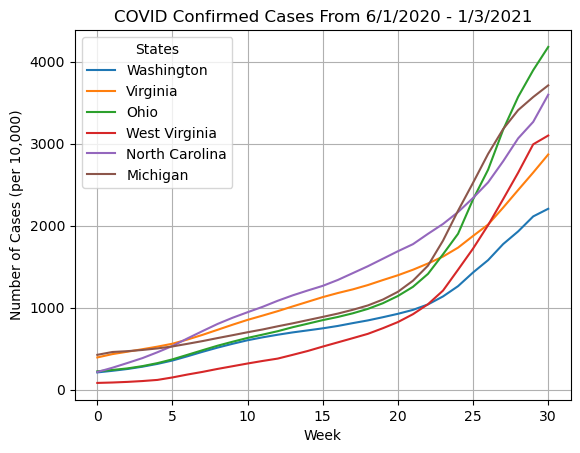

In [1019]:
case_norm = all_state_cases_norm.loc[:,['WA Normalization','VA Normalization','OH Normalization','WV Normalization','NC Normalization','MI Normalization']]
case_norm.plot(kind='line')
plt.title('COVID Confirmed Cases From 6/1/2020 - 1/3/2021')
plt.xlabel('Week')
plt.ylabel('Number of Cases (per 10,000)')
#Rename the legend
legend_labels = ['Washington', 'Virginia', 'Ohio', 'West Virginia', 'North Carolina', 'Michigan']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.grid()
plt.show()

From the graph above all of the states had an increase in the number of cases around the 22nd week which is where people are traveling and gathering for Thanksgiving Day. After Thanksgiving is Christmas and New Year's Day, both of which are major holidays where people are traveling and coming into contact with people. 

### Death Normalization

Normalize the deaths for each state (by 10,000)

In [982]:
wa_death_norm = death_normalization('WA')
wv_death_norm = death_normalization('WV')
va_death_norm = death_normalization('VA')
nc_death_norm = death_normalization('NC')
oh_death_norm = death_normalization('OH')
mi_death_norm = death_normalization('MI')

Merge them all together

In [984]:
all_state_deaths_norm = pd.merge(wa_death_norm,va_death_norm, on='Week')
all_state_deaths_norm = all_state_deaths_norm.merge(oh_death_norm, on='Week')
all_state_deaths_norm = all_state_deaths_norm.merge(wv_death_norm, on='Week')
all_state_deaths_norm = all_state_deaths_norm.merge(nc_death_norm, on='Week')
all_state_deaths_norm = all_state_deaths_norm.merge(mi_death_norm, on='Week')
# all_state_deaths_norm

Drop the duplicated rows

In [987]:
all_state_deaths_norm = all_state_deaths_norm.drop_duplicates(subset= 'Week', keep= 'first')
# all_state_deaths_norm

Plot the number of deaths per 10,000 for each of the states.

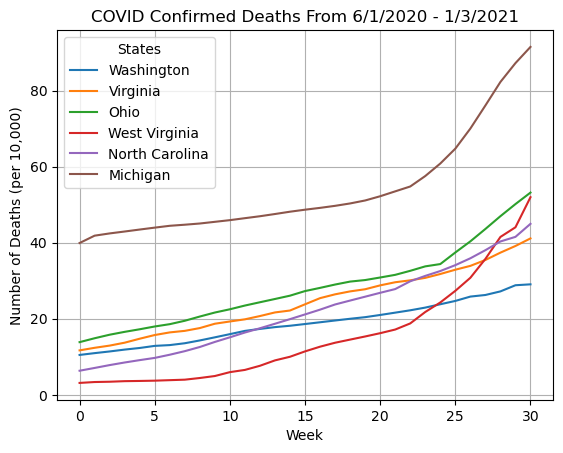

In [1023]:
death_norm = all_state_deaths_norm.loc[:,['WA Normalization','VA Normalization','OH Normalization','WV Normalization','NC Normalization','MI Normalization']]
death_norm.plot(kind='line')
plt.title('COVID Confirmed Deaths From 6/1/2020 - 1/3/2021')
plt.xlabel('Week')
plt.ylabel('Number of Deaths (per 10,000)')
#Rename the legend
legend_labels = ['Washington', 'Virginia', 'Ohio', 'West Virginia', 'North Carolina', 'Michigan']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.grid()
plt.show()

From the graph above, the number of deaths greatly differs for Michigan which could be caused by various factors such as poverty, access to healthcare, age, and vaccination rates. The rest of the states show similar trends.

### Five Counties in Washington

Thee five counties that I picked are Benton County, King, County, Pierce County, Snohomish County, and Yakima County

Function to find the sum of each county by the week. Modified version of weekly_sum

In [844]:
def weekly_sum_by_county(dataframe, state_name):
    state_df = dataframe[dataframe['State'] == state_name]
    state_columns = state_df.iloc[:, :4]
    
    # Convert column names to datetime format
    state_df.columns = pd.to_datetime(state_df.columns, format='%Y-%m-%d', errors='coerce')

    # Define weekly groups
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')
    
    # Initialize an empty DataFrame for weekly sums
    weekly_sums = pd.DataFrame(index=state_df.index)

    for i, week_end in enumerate(weekly_groups):
        # Define the start of the week
        week_start = week_end - pd.Timedelta(days=6)
        
        # Select range of columns
        week_columns = state_df.loc[:, (state_df.columns >= week_start) & (state_df.columns <= week_end)]
        
        # Sum across rows for the week
        weekly_total = week_columns.sum(axis=1)  
        
        # Add the weekly total to the weekly_sums DataFrame as a new column
        weekly_sums[f'week {i + 1}'] = weekly_total

    weekly_sums = pd.concat([state_columns,weekly_sums],axis= 1)
    
    return weekly_sums.reset_index(drop=True)  
    

#### Cases

In [930]:
wa_cases = weekly_sum_by_county(cases,'WA')
wa_cases = wa_cases.loc[[3, 17, 27, 31, 39]] 
wa_cases = wa_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS']).T
# 3-Benton  17-King  27-Pierce  31-Snohomish 39-Yakima
# wa_cases

Plotting the COVID cases in the five counties 

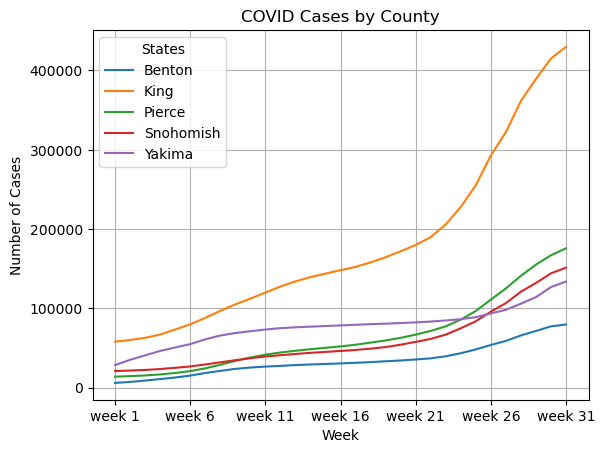

In [958]:
wa_cases.plot(kind='line')
plt.title('COVID Cases by County')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.grid()
legend_labels = ['Benton', 'King', 'Pierce', 'Snohomish', 'Yakima']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.plot()

From the graph above, there is an slight increase around week 7 and a significant increase in the number of cases around week 22. The 22nd week is when Thanksgiving happens. After Thanksgiving is Christmas and New Year's Day at weeks 27 and 28 which also shows an increase in the number of cases

[]

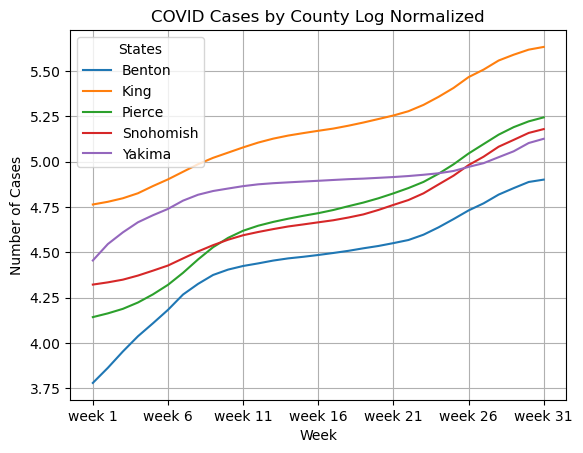

In [964]:
wa_log = np.log10(wa_cases)
wa_log.plot(kind='line')
plt.title('COVID Cases by County Log Normalized')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.grid()
legend_labels = ['Benton', 'King', 'Pierce', 'Snohomish', 'Yakima']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.plot()


After applying the log normalization, there is an increase around the third week which could be caused from local events. There is also the increase at week 22 as mentioned earlier.

#### Deaths

In [861]:
wa_death = weekly_sum_by_county(deaths,'WA')
wa_death = wa_death.loc[[3, 17, 27, 31, 39]] 
wa_death = wa_death.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS']).T

[]

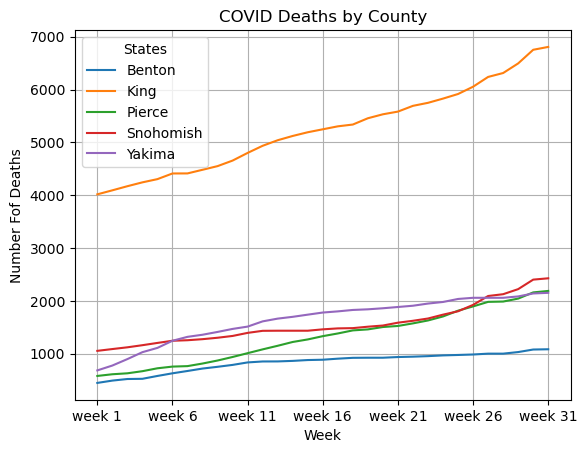

In [1007]:
wa_death.plot(kind='line')
plt.title('COVID Deaths by County')
plt.xlabel('Week')
plt.ylabel('Number Fof Deaths')
plt.grid()
legend_labels = ['Benton', 'King', 'Pierce', 'Snohomish', 'Yakima']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.plot()

From the graph above, there is an overall steady increase in the number of deaths.

[]

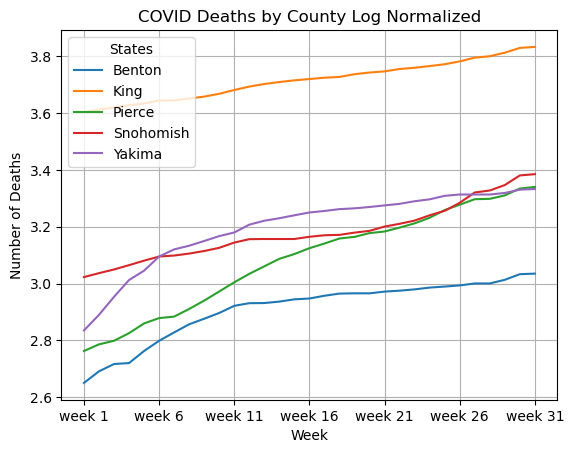

In [976]:
wa_death_log = np.log10(wa_death)

wa_death_log.plot(kind='line')
plt.title('COVID Deaths by County Log Normalized')
plt.xlabel('Week')
plt.ylabel('Number of Deaths')
plt.grid()
legend_labels = ['Benton', 'King', 'Pierce', 'Snohomish', 'Yakima']

plt.legend(labels = legend_labels, title = 'States', loc = 'upper left')
plt.plot()

After applying the log, at around week seven. Around week 5 is Independence Day (July 4). If you take into account the incubation period for COVID-19 and the time for the person's condition to worsen, it would make sense that the number of deaths would increase in the next two to three weeks. 